# Spectrally Incoherent Array

Another notebook in the series of analysis of Mark's trap array design. 

This notebook explores the effect of Gaussian array generation with polychromatic fields. 

In [2]:
## general imports
import numpy as np
from numpy import *
from numpy.fft import fft,fft2,fftshift,ifftshift

from scipy.special import j0, j1
from matplotlib import colors
import matplotlib.pyplot as plt
from time import time
from random import random as rand

## local imports
import os,sys
sys.path.append(os.path.join("..","."))
from field_funcs import * # my helper functions
from physconsts import *

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

# image path 
imagedir = os.path.join('..','images')
print("images saved in", imagedir)

def lorentzian(x, x0, Gamma):
    """Lorentzian function of x, w/ mean x0 and FWHM Gamma"""
    return (1/pi)*(Gamma/2)/((x-x0)**2+(Gamma/2)**2)

images saved in ..\images


## Monochromatic dark trap array

Sanity check before polychromatic field propagation

b=0.002516, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000045, zTalboty=0.000045
f - z2 = 0.0
calculated field2 in 0.7719409465789795 s
f - z2 = 0.0
calculated field2 in 0.7569329738616943 s
f - z2 = -4.482424242424274e-05
calculated field2 in 0.7909526824951172 s


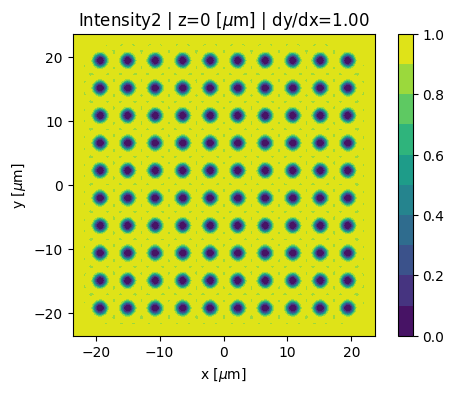

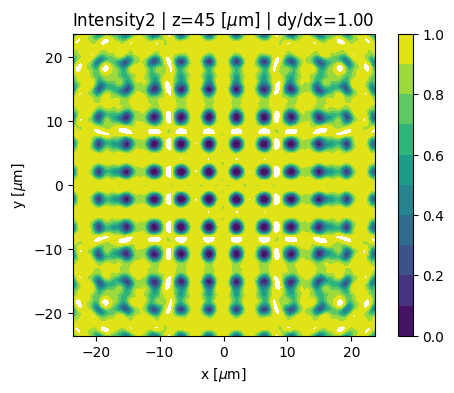

In [4]:
# single component propagation sanity check
## physics and lens params
lmbda = 8.25e-7
k = 2*pi/lmbda
f1 = 0.5 # lens focal length [m]
f2 = 0.005
A0 = 1 # input field amplitude

## input mask params
r1 = 0.50 # reflectivity of the spots for dark traps. if not applicable, just set to 1. trust me.
r2 = 1 # dual grid has fully transmitting spots

a = 1e-4 # spot radius
dx = 4.3*a # grid periodicity
dy = dx 
b = f1*3.8317/(a*k) # fourier plane filter radius
xnum = ynum = 10 # number of grid points in each dimension

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

# build the mask -- backplate and partially transmitting spots
pts = 1000
phi_std=None # [rad]
pos_std=None
r_aper = .75 # aperture reflectivity
t_plate = 1 # plate transmissivity
mask, x0pts, w = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1-r_aper, plate=t_plate)

# FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
padding = pts//2 # int(3*pts/2) #TODO set
rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
field1,x1pts = lens_xform(f1,mask,b,f1,k,x0pts,rr0,padding, masked=False,padval=1)

# OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
padding = pts//2 #int(3*pts/2)

zvals = [f2, f2 + zTalbotx]

for z2 in zvals: 
    
    field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True)

    I2_xy = conjugate(field2)*field2
    if f2 - z2 == 0:
        I2xy_max = amax(I2_xy)
    I2_xy = I2_xy/I2xy_max

    scl = 1e6
    fig, ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
    fig.dpi=100
    title = rf'Intensity2 | z={(z2 - f2)*1e6:0.0f} [$\mu$m]'
    title += f' | dy/dx={dy/dx:0.2f}' #Uniform input $\phi$
    # title += '\n Normalized to focal plane intensity'
    ax.set_title(title)
    if f2 - z2 == 0:
        cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
    else:
        cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
    # fig.colorbar(cax, ticks=arange(0,1.2,.2))
    fig.colorbar(cax)

## Polychromatic dark trap array
Simulate propagation of a polychromatic field through array generator.

$E(\rho_1,z_1) = \sum_j E_j(\rho_1,z_1) \exp(-i(\omega_j t + k_j z + \phi_j)))$ where I dropped the positive frequency component

Then the field having gone through Fresnel diffraction to plane z2 is

$E(z2) = \frac{1}{2\pi z_2}\sum_j \exp(-(i \omega_j t  + k_j z + \phi_j)) \mathcal{F}[E_j(\rho_1,z_1) \exp(k\rho_1^2/z_1)]$

showing that the resultant field should just be the sum of the Fresnel diffracted field components 

length units are m:
b=0.002455, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000046, zTalboty=0.000046
Power spectrum FWHM: 4626.25 GHz
Coherence length: 0.000021


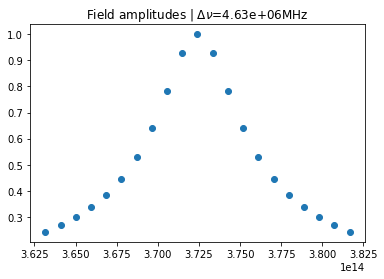

In [39]:
## physics and lens params
# lengths in m

lmbda = 8.05e-7
dlmbda = 10e-9 # FWHM
nu0 = c/lmbda
dnu = dlmbda*nu0**2/c # FWHM of freq. spectrum

# lorentzian scaled to have peak value = 1
L = lambda nu: lorentzian(nu, nu0, dnu)/lorentzian(nu0,nu0,dnu)
k = 2*pi/lmbda

f1 = 0.5 # lens focal length [m]
f2 = 0.005
A0 = 1 # input field amplitude

## input mask params
r1 = 0.50 # reflectivity of the spots for dark traps. if not applicable, just set to 1. trust me.
r2 = 1 # dual grid has fully transmitting spots

a = 1e-4 # spot radius
dx = 4.3*a # grid periodicity
dy = dx 
b = f1*3.8317/(a*k) # fourier plane filter radius
xnum = ynum = 10 # number of grid points in each dimension

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print("length units are m:")
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
print(f'Power spectrum FWHM: {dnu/1e9:0.2f} GHz')
print(f'Coherence length: {c/(pi*dnu):0.6f}')

"""Discretize the Lorentzian power spectral density lineshape function, 
and then use the sqrt amplitude of each PSD amplitude as the field 
amplitude. We don't know any phase information so just pick a random phase 
from a flat distribution. """

# generate frequency components

halfwidth = 2*dnu # the abs value of the spectral domain to sample
components=21
nu_pts = linspace(nu0-halfwidth,nu0+halfwidth,components)
nu_pts.sort()

plt.title(rf"Field amplitudes | $\Delta \nu$={dnu/1e6:0.3}MHz")
plt.scatter(nu_pts, sqrt(L(nu_pts)))

In [40]:
# build the mask -- backplate and partially transmitting spots
pts = 1000
phi_std=None # [rad]
pos_std=None
r_aper = .75 # aperture reflectivity
t_plate = 1 # plate transmissivity
mask, x0pts, w = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1-r_aper, plate=t_plate)
focal_int = np.zeros(mask.shape,float)
talbot_int = np.zeros(mask.shape,float)

# iterate over frequency components
for i,nu in enumerate(nu_pts):
    
    k = 2*pi*nu/c # wave number

    # input field 
    field0 = mask*sqrt(L(nu))*exp(-1j*2*pi*rand())

    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding = pts//2 # int(3*pts/2) #TODO set
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,mask,b,f1,k,x0pts,rr0,padding, masked=False,
                              padval=1,logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    padding = pts//2 #int(3*pts/2)

    zvals = [f2, f2 + zTalbotx]

    for z2 in zvals: 

        field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                                 logging=False)
        
        if z2 == f2:
            focal_int += real(field2*conjugate(field2))
        else:
            talbot_int += real(field2*conjugate(field2))
            
    print(f"step {i} completed")

step 0 completed
step 1 completed
step 2 completed
step 3 completed
step 4 completed
step 5 completed
step 6 completed
step 7 completed
step 8 completed
step 9 completed
step 10 completed
step 11 completed
step 12 completed
step 13 completed
step 14 completed
step 15 completed
step 16 completed
step 17 completed
step 18 completed
step 19 completed
step 20 completed


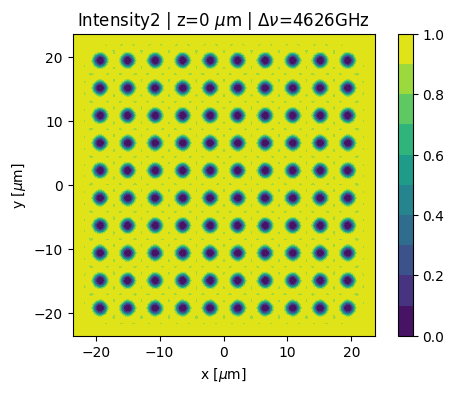

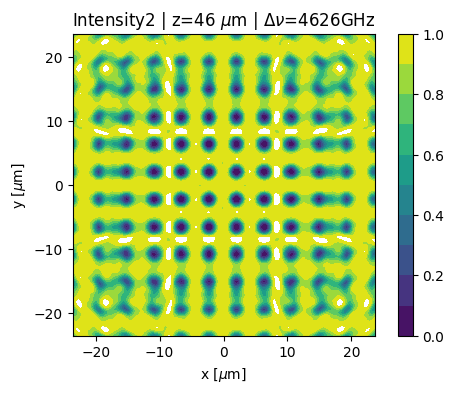

In [41]:
# plot field in focal and talbot planes and save

savefig = False
for output_int,z2 in zip([focal_int,talbot_int],zvals):
    I2_xy = output_int
    if f2 - z2 == 0:
        I2xy_max = amax(I2_xy)
    I2_xy /= I2xy_max

    scl = 1e6
    fig, ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
    fig.dpi=100
    title = rf'Intensity2 | z={(z2 - f2)*1e6:0.0f} $\mu$m'
    title += rf' | $\Delta \nu$={dnu/1e9:0.0f}GHz' #Uniform input $\phi$
    # title += '\n Normalized to focal plane intensity'
    ax.set_title(title)
    if f2 - z2 == 0:
        cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
    else:
        cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
    # fig.colorbar(cax, ticks=arange(0,1.2,.2))
    fig.colorbar(cax)
    
    if savefig:
        if not phases:
            fname = os.path.join(imagedir, 
            f'plot_polychrm_{int(dnu/1e9)}MHz_monophi_z2_{int(abs((f2 - z2)*1e6))}um_{components}pts_{xnum1}x{ynum1}.png')
        else:
            fname = os.path.join(imagedir, 
            f'plot_polychrm_{int(dnu/1e9)}MHz_whitephi_z2_{int(abs((f2 - z2)*1e6))}um_{components}pts_{xnum1}x{ynum1}.png')
        plt.savefig(fname, bbox_inches='tight')
        print(f"saved file to {fname}")
savefig = False

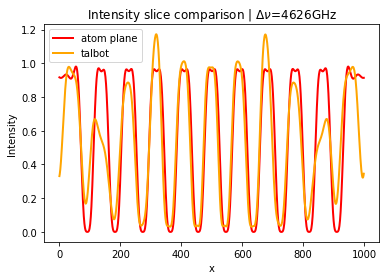

In [42]:
savefig=False
fig, ax = plt.subplots()
ax.set_title(rf'Intensity slice comparison | $\Delta\nu$={dnu/1e9:0.0f}GHz') #Uniform input $\phi$
ax.set_xlabel("x")
ax.set_ylabel("Intensity")
I2xy_max = 1
for field_int,label,color,lw in zip([abs(field0)**2,focal_int,talbot_int],['input','atom plane','talbot'],['teal','red','orange'],['1','2','2']):
    # because of the ordering of labels/fields, the talbot plane is scaled to the atom plane
    
    I2_xy = field_int
    if label == 'atom_plane':
        I2xy_max = amax(field_int)
    I2_xy /= I2xy_max

    if label != 'input':
        ax.plot(range(pts), I2_xy[450,:],lw=lw,label=label,c=color)
    
ax.legend(loc='upper left')
if savefig:
    fname = os.path.join(imagedir, f'plot_polychrm_{int(dnu/1e6)}MHz_monophi_z2_{int(abs((f2 - z2)*1e6))}um_xzslices_{xnum1}x{ynum1}.png')
    plt.savefig(fname, bbox_inches='tight')
    print(f"saved file to {fname}")
    savefig=False